# 전기 사용량을 예측해보자~

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd ./drive/MyDrive/Colab Notebooks
!pwd

/content/drive/MyDrive/Colab Notebooks
/content/drive/MyDrive/Colab Notebooks


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# 전기 사용량, 온도 데이터 per 1hour
data = pd.read_csv("./data/energy.csv")
print(data.shape)
data.tail() # 데이터 끝부분 확인 <-> head()

(26304, 3)


,timestamp,load,temp
26299,2014-12-31 19:00:00,4012.0,18.000000
26300,2014-12-31 20:00:00,3856.0,16.666667
26301,2014-12-31 21:00:00,3671.0,17.000000
26302,2014-12-31 22:00:00,3499.0,15.333333
26303,2014-12-31 23:00:00,3345.0,15.333333


In [5]:
energy = pd.read_csv("./data/energy.csv", parse_dates=["timestamp"], index_col="timestamp") # timestamp 를 날짜 타입으로 읽으며, index로 설정한다. 시간을 계산하기에 용이하다.
energy.head()

,load,temp
timestamp,,
2012-01-01 00:00:00,2698.0,32.000000
2012-01-01 01:00:00,2558.0,32.666667
2012-01-01 02:00:00,2444.0,30.000000
2012-01-01 03:00:00,2402.0,31.000000
2012-01-01 04:00:00,2403.0,32.000000


In [6]:
# 필요없는 온도 값 삭제
del energy["temp"]

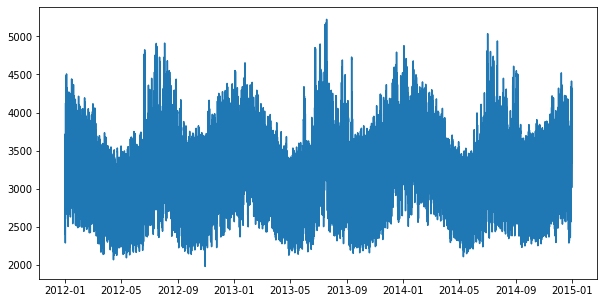

In [7]:
plt.figure(figsize=(10,5)) # 가로가 좀 더 길게~
plt.plot(energy)
plt.show()

# 시간의 흐름을 판단해야 하기에 데이터를 랜덤 샘플링 하지 않아야 한다.
- (train, validation, text)
# 스케일링
- 딥러닝 학습 시 최적점을 찾아가는 속도 개선을 위해 컬럼 스케일링 진행
- RNN 데이터 구조로 변경 (sample, time step, feature)

In [8]:
from sklearn.preprocessing import MinMaxScaler# 최대값과 최소값을 이용해서 스케일링 : 0~1 사이값 객체

scaler = MinMaxScaler() # 인스턴스화
scaler.fit(energy) # 현재 데이터의 최소값, 최대값 추출
energy["load"] = scaler.transform(energy) #스케일링 후 load 컬럼에 덮어씌우기
energy.head()

,load
timestamp,
2012-01-01 00:00:00,0.221572
2012-01-01 01:00:00,0.178428
2012-01-01 02:00:00,0.143297
2012-01-01 03:00:00,0.130354
2012-01-01 04:00:00,0.130663


### RNN 으로 학습하기 좋게 데이터를 바꿔보자
- 과거 6시간을 학습하고 다음 1시간을 정답 y로 학습하자

In [9]:
energy_shifted = energy.copy() # 원본 데이터 그~대로 복사
energy_shifted["y+1"] = energy_shifted["load"].shift(-1, freq="H") # shifted 밀다 : 데이터를 미는 것! +1 한 칸만 밀어라 -1 한 칸만 당겨라 , freq : 어떤 주기로 밀래? = "시간기준 H"
energy_shifted

,load,y+1
timestamp,,
2012-01-01 00:00:00,0.221572,0.178428
2012-01-01 01:00:00,0.178428,0.143297
2012-01-01 02:00:00,0.143297,0.130354
2012-01-01 03:00:00,0.130354,0.130663
2012-01-01 04:00:00,0.130663,0.146071
...,...,...
2014-12-31 19:00:00,0.626502,0.578428
2014-12-31 20:00:00,0.578428,0.521418
2014-12-31 21:00:00,0.521418,0.468413


In [10]:
# load_t 5 ~ 0 : 학습 데이터
# y+1 : 정답 데이터
energy_shifted["load_t-5"] = energy_shifted["load"].shift(5, freq="H") # 아래로 5번 밀기 
energy_shifted["load_t-4"] = energy_shifted["load"].shift(4, freq="H") 
energy_shifted["load_t-3"] = energy_shifted["load"].shift(3, freq="H") 
energy_shifted["load_t-2"] = energy_shifted["load"].shift(2, freq="H") 
energy_shifted["load_t-1"] = energy_shifted["load"].shift(1, freq="H") 
energy_shifted["load_t-0"] = energy_shifted["load"].shift(0, freq="H") 

# timestamp 가 6이기 때문에 5시부터 학습을 시작한다.
energy_shifted.head(10) # 앞 10행 확인!

#총 데이터가 약 2만개, 손실하는 데이터 5개 뿐!

,load,y+1,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t-0
timestamp,,,,,,,,
2012-01-01 00:00:00,0.221572,0.178428,NaN,NaN,NaN,NaN,NaN,0.221572
2012-01-01 01:00:00,0.178428,0.143297,NaN,NaN,NaN,NaN,0.221572,0.178428
2012-01-01 02:00:00,0.143297,0.130354,NaN,NaN,NaN,0.221572,0.178428,0.143297
2012-01-01 03:00:00,0.130354,0.130663,NaN,NaN,0.221572,0.178428,0.143297,0.130354
2012-01-01 04:00:00,0.130663,0.146071,NaN,0.221572,0.178428,0.143297,0.130354,0.130663
2012-01-01 05:00:00,0.146071,0.179045,0.221572,0.178428,0.143297,0.130354,0.130663,0.146071
2012-01-01 06:00:00,0.179045,0.228043,0.178428,0.143297,0.130354,0.130663,0.146071,0.179045
2012-01-01 07:00:00,0.228043,0.288752,0.143297,0.130354,0.130663,0.146071,0.179045,0.228043
2012-01-01 08:00:00,0.288752,0.346995,0.130354,0.130663,0.146071,0.179045,0.228043,0.288752


In [11]:
energy_shifted.dropna(inplace=True) # inplace : 현재 데이터에 적용 및 저장까지 할래? True
energy_shifted.head(10)

,load,y+1,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t-0
timestamp,,,,,,,,
2012-01-01 05:00:00,0.146071,0.179045,0.221572,0.178428,0.143297,0.130354,0.130663,0.146071
2012-01-01 06:00:00,0.179045,0.228043,0.178428,0.143297,0.130354,0.130663,0.146071,0.179045
2012-01-01 07:00:00,0.228043,0.288752,0.143297,0.130354,0.130663,0.146071,0.179045,0.228043
2012-01-01 08:00:00,0.288752,0.346995,0.130354,0.130663,0.146071,0.179045,0.228043,0.288752
2012-01-01 09:00:00,0.346995,0.368259,0.130663,0.146071,0.179045,0.228043,0.288752,0.346995
2012-01-01 10:00:00,0.368259,0.370108,0.146071,0.179045,0.228043,0.288752,0.346995,0.368259
2012-01-01 11:00:00,0.370108,0.371341,0.179045,0.228043,0.288752,0.346995,0.368259,0.370108
2012-01-01 12:00:00,0.371341,0.359938,0.228043,0.288752,0.346995,0.368259,0.370108,0.371341
2012-01-01 13:00:00,0.359938,0.352234,0.288752,0.346995,0.368259,0.370108,0.371341,0.359938


### 데이터 나누기
- 2012~ 2014

In [12]:
validation_start = "2014-09-01 00:00:00" # 검증 데이터 시작
test_start = "2014-11-01 00:00:00"

train = energy_shifted[energy_shifted.index < validation_start] # 불리언 인덱싱
validation = energy_shifted[(energy_shifted.index > validation_start) & (energy_shifted .index < test_start)] # 검증보다 크고 테스트보다 작은 검증 데이터 색출
test = energy_shifted[energy_shifted.index > test_start] # 테스트 날짜보다 큰 거 : 테스 날짜보다 나중에 온 것

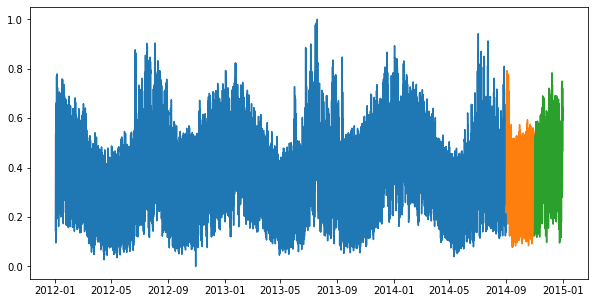

In [13]:
plt.figure(figsize=(10,5))
plt.plot(train["load"])
plt.plot(validation["load"])
plt.plot(test["load"])
plt.show()

## 데이터 분리

In [14]:
# 현재 feature 수가 빠져 있음
X_train = train.loc[:, "load_t-5" : "load_t-0"] # 문제 데이터
y_train = train["y+1"] # 정답 데이터
X_val = validation.loc[:, "load_t-5" : "load_t-0"]
y_val = validation["y+1"]
X_test = test.loc[:, "load_t-5" : "load_t-0"]
y_test = test["y+1"] 

# 2차원
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(23371, 6) (23371,)
(1463, 6) (1463,)
(1462, 6) (1462,)


### RNN 학습을 위한 2 >> 3 차원 변경
- 과거5시간, 과거4 시간, 과거 3시간, 과거 2시간 , 과거 1시간

In [15]:
# 샘플 개수, timestamp, feature 개수 >> 3차원
# feature 순환하는 한 개의 퍼셉트론에 몇 개의 정보를 동시에 넣을지?
X_train = X_train.values.reshape(23371, 6, 1) # DataFrame 에는 reshape 가 없다. 따라서 values 를 거쳐 사용한다.
X_val = X_val.values.reshape(1463, 6, 1)
X_test = X_test.values.reshape(1462, 6, 1)

## 모델링 및 학습

In [16]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import InputLayer, Dense, LSTM # LSTM : 순환하는 RNN 레이어

model1 = Sequential()
model1.add(InputLayer(input_shape=(6,1))) # input_shape : 샘플은 의미 없고 들어가는 한 개의 데이터에 관해 입력!
model1.add(LSTM(32, return_sequences=True))
model1.add(LSTM(16))
model1.add(Dense(1)) # 수치값을 예측하기에 데이터 그대로 보내고

model1.compile(loss="mean_squared_error", # 수치값이기에 MSE
              optimizer = "Adam") # 수치 데이터이기에 metrics 사용하지 않는다.

h1 = model1.fit(X_train, y_train,
           validation_data = (X_val, y_val), # 우리가 직접 쪼개놓았기에 내장함수를 사용하지 않는다.
          epochs = 20)

Epoch 1/20
731/731 [==============================] - 11s 10ms/step - loss: 0.0104 - val_loss: 0.0035
Epoch 2/20
731/731 [==============================] - 6s 9ms/step - loss: 0.0017 - val_loss: 9.3166e-04
Epoch 3/20
731/731 [==============================] - 6s 9ms/step - loss: 7.7304e-04 - val_loss: 5.6897e-04
Epoch 4/20
731/731 [==============================] - 6s 9ms/step - loss: 6.7718e-04 - val_loss: 5.5052e-04
Epoch 5/20
731/731 [==============================] - 6s 9ms/step - loss: 6.2705e-04 - val_loss: 5.4492e-04
Epoch 6/20
731/731 [==============================] - 6s 9ms/step - loss: 6.1414e-04 - val_loss: 6.8763e-04
Epoch 7/20
731/731 [==============================] - 6s 9ms/step - loss: 5.8514e-04 - val_loss: 4.9001e-04
Epoch 8/20
731/731 [==============================] - 6s 9ms/step - loss: 5.7462e-04 - val_loss: 8.0891e-04
Epoch 9/20
731/731 [==============================] - 7s 9ms/step - loss: 5.6525e-04 - val_loss: 6.9494e-04
Epoch 10/20
731/731 [=================

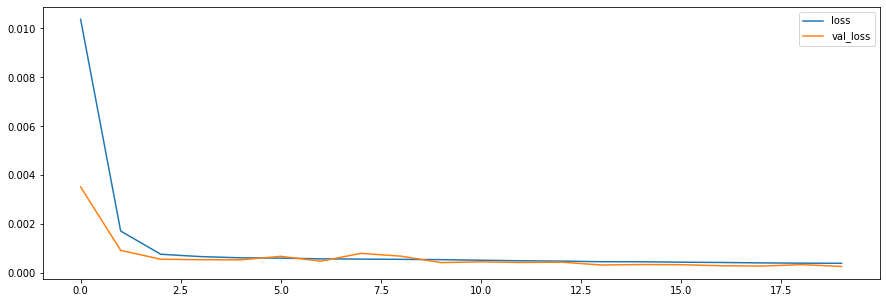

In [17]:
plt.figure(figsize=(15,5))
plt.plot(h1.history["loss"], label="loss")
plt.plot(h1.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

## 모델 예측 및 결과 시각화

In [18]:
result = test[["y+1"]] # 테스트 데이터의 정답 추출
result["pre"] = model1.predict(X_test)
result 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,y+1,pre
timestamp,,
2014-11-01 01:00:00,0.126656,0.127083
2014-11-01 02:00:00,0.124191,0.124470
2014-11-01 03:00:00,0.135593,0.138146
2014-11-01 04:00:00,0.166718,0.172070
2014-11-01 05:00:00,0.226502,0.230458
...,...,...
2014-12-31 18:00:00,0.626502,0.628584
2014-12-31 19:00:00,0.578428,0.568159
2014-12-31 20:00:00,0.521418,0.526684


# 스케일링 전의 데이터 단위로 바꾸기 : inverse_scaling  

In [22]:
result[["y+1", "pre"]] = scaler.inverse_transform(result)
result

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


,y+1,pre
timestamp,,
2014-11-01 01:00:00,2390.0,2391.383476
2014-11-01 02:00:00,2382.0,2382.905812
2014-11-01 03:00:00,2419.0,2427.283425
2014-11-01 04:00:00,2520.0,2537.368493
2014-11-01 05:00:00,2714.0,2726.837052
...,...,...
2014-12-31 18:00:00,4012.0,4018.754395
2014-12-31 19:00:00,3856.0,3822.674356
2014-12-31 20:00:00,3671.0,3688.088181


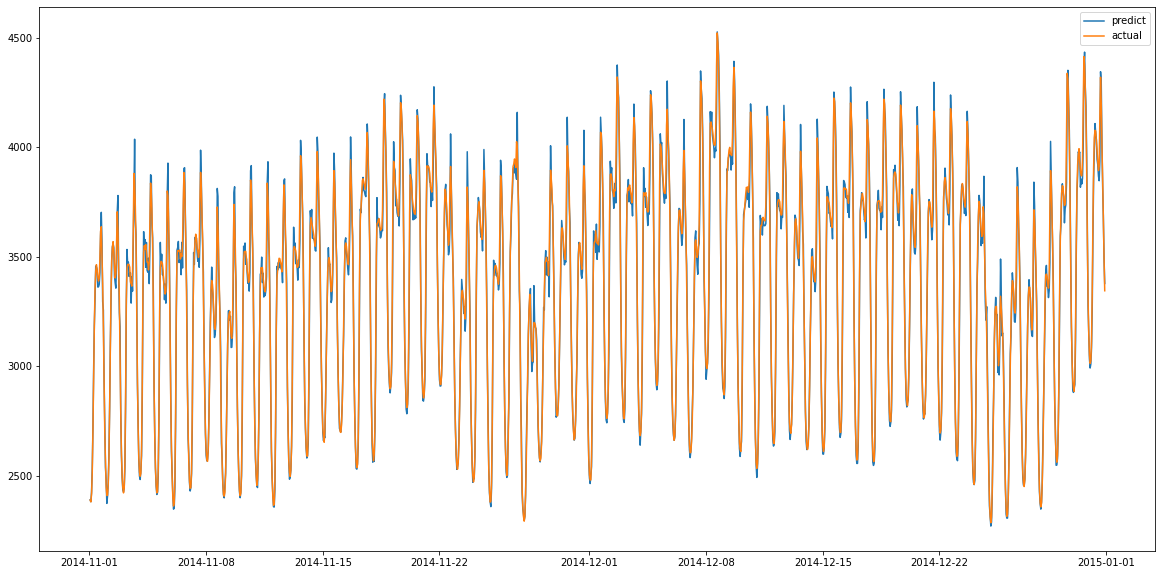

In [27]:
plt.figure(figsize=(20,10))
plt.plot(result["pre"], label = "predict")
plt.plot(result["y+1"], label = "actual")
plt.legend()
plt.show()